In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import os
import operator
import colorcet
from sys import stdout as so
import md_tools

In [2]:
# Dictionary with all parameter keywords and desired values.
P = {}

# Add some entries.
P["kalman_epsilon"] = np.logspace(-3, 3, num=7)
#P["kalman_eta"] = np.logspace(-6, 1, num=8)
#P["kalman_q0"] = np.logspace(-2, 2, num=5)
P["kalman_lambda_short"] = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
P["kalman_nue_short"] = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
#P["kalman_lambda_short"] = np.linspace(0.90, 0.999, num=8)
#P["kalman_nue_short"] = np.linspace(0.95, 0.9999, num=8)
dim = len(P)
print dim

3


In [3]:
seeds = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [4]:
# Sort keys alphabetically.
keys = sorted(P.keys())
print keys

['kalman_epsilon', 'kalman_lambda_short', 'kalman_nue_short']


In [5]:
# Create grid of sample points.
samples = np.meshgrid(*[P[k] for k in keys])
# Flatten grid.
samples = np.array([sample.flatten() for sample in samples]).T
np.shape(samples)

(700, 3)

In [6]:
lc = {}
so.write("SAMPLE")
for k in keys:
    so.write(" {0:>24s}".format(k))
so.write("\n")
so.write("------------------------------------------------------------------------------\n")
for i in range(len(samples)):
    sample = samples[i]
    key = tuple(sample)
    so.write("{0:6d}".format(i))
    for j in range(len(sample)):
        cmd_sed = "sed -i \"s/^{0:s} .*$/{0:s} {1:16.8E}/g\" input.nn".format(keys[j], sample[j])
        so.write(" {0:24.8E}".format(sample[j]))
        os.system(cmd_sed)
    so.write("\n")
    lc[key] = []
    for s in seeds:
        cmd_sed = "sed -i \"s/^{0:s} .*$/{0:s} {1:d}/g\" input.nn".format("random_seed", s)
        os.system(cmd_sed)
        cmd_train = "../nnp-train > train.log"
        os.system(cmd_train)
        lc[key] = np.append(lc[key], md_tools.readColsFromFile("learning-curve.out", {"Epoch" : 1, "Energy" : 2, "Force" : 4}))
        cmd_copy = "cp learning-curve.out learning-curve.out.{0:d}.{1:d}".format(i, s)
        os.system(cmd_copy)

SAMPLE           kalman_epsilon      kalman_lambda_short         kalman_nue_short
------------------------------------------------------------------------------
     0           1.00000000E-03           9.00000000E-01           9.00000000E-01
     1           1.00000000E-03           9.00000000E-01           9.10000000E-01
     2           1.00000000E-03           9.00000000E-01           9.20000000E-01
     3           1.00000000E-03           9.00000000E-01           9.30000000E-01
     4           1.00000000E-03           9.00000000E-01           9.40000000E-01
     5           1.00000000E-03           9.00000000E-01           9.50000000E-01
     6           1.00000000E-03           9.00000000E-01           9.60000000E-01
     7           1.00000000E-03           9.00000000E-01           9.70000000E-01
     8           1.00000000E-03           9.00000000E-01           9.80000000E-01
     9           1.00000000E-03           9.00000000E-01           9.90000000E-01
    10           1.

In [7]:
results = {}
for i in range(len(samples)):
    key = tuple(samples[i])
    minEnergy = []
    minForce = []
    for c in lc[key]:
        minIndex, minValue = min(enumerate(c["Energy"]), key=operator.itemgetter(1))
        minEnergy = np.append(minEnergy, minValue)
        minIndex, minValue = min(enumerate(c["Force"]), key=operator.itemgetter(1))
        minForce = np.append(minForce, minValue)
    results[i] = [min(minEnergy), np.mean(minEnergy), min(minForce), np.mean(minForce)]

In [8]:
def log_tick_formatter(val, pos=None):
    return "{:.0e}".format(10**val)
    #return "{:d}".format(val)

def plotRMSE(column):
    fig, ax1 = plt.subplots()
    ax1 = fig.add_subplot(111, projection='3d')
    X = []
    Y = []
    Z = []
    C = []
    for i in range(len(samples)):
        X = np.append(X, samples[i][0])
        Y = np.append(Y, samples[i][1])
        Z = np.append(Z, samples[i][2])
        C = np.append(C, results[i][column])
    cbmin = C.min()
    cbmax = C.max()
    #cbmin = 1E-1
    #cbmax = 1E+1
    #ax1.loglog()
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax1.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax1.set_xlabel(r'{0:s}'.format(keys[0]))
    ax1.set_ylabel(r'{0:s}'.format(keys[1]))
    ax1.set_zlabel(r'{0:s}'.format(keys[2]))
    #sc = ax1.scatter(X, Y, c=C, norm=colors.LogNorm(vmin=cbmin, vmax=cbmax), cmap=colorcet.cm["rainbow"], s=1000)
    sc = ax1.scatter(np.log10(X), np.log10(Y), np.log10(Z), c=C, norm=colors.LogNorm(vmin=cbmin, vmax=cbmax), cmap=colorcet.cm["rainbow"], s=100)
    #for i in range(len(samples)):
        #ax1.annotate(r'{0:d}'.format(i), xy=(X[i], Y[i]))
        #ax1.text(np.log10(X[i]), np.log10(Y[i]), np.log10(Z[i]),  r'{0:d}'.format(i))
    fig.colorbar(sc, label=r'Best energy training result')

<IPython.core.display.Javascript object>


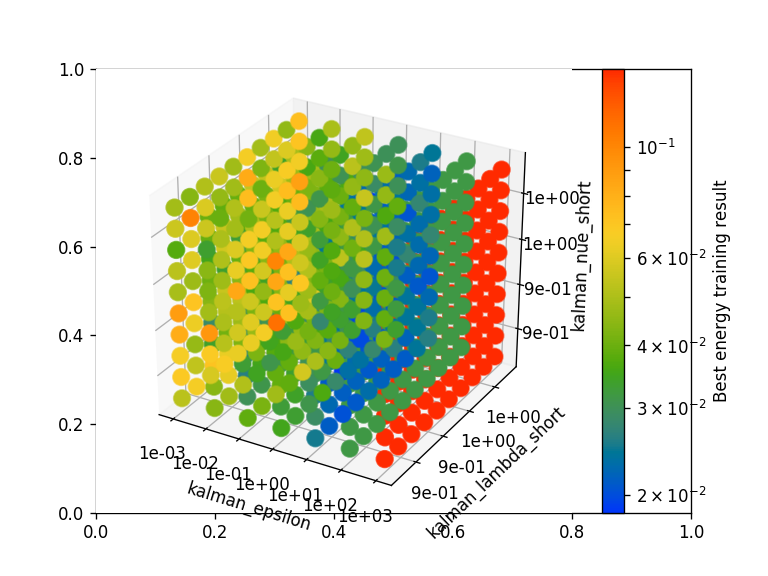

<IPython.core.display.Javascript object>


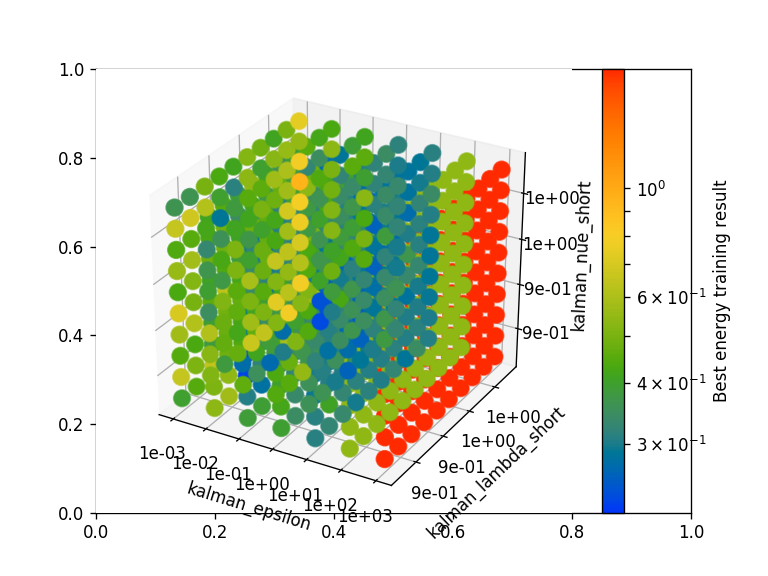

In [9]:
plotRMSE(1)
plotRMSE(3)

In [10]:
r = [results[i] for i in range(len(results))]
minEnergy = sorted(enumerate(r), key=lambda x : x[1][0])[0]
meanEnergy = sorted(enumerate(r), key=lambda x : x[1][1])[0]
minForce = sorted(enumerate(r), key=lambda x : x[1][2])[0]
meanForce = sorted(enumerate(r), key=lambda x : x[1][3])[0]
so.write("SAMPLE")
for k in keys:
    so.write(" {0:>24s}".format(k))
so.write(" {0:>16s}\n".format("RMSE"))
so.write("------------------------------------------------------------------------------\n")
count = 0
for rmseMin in [minEnergy, meanEnergy, minForce, meanForce]:
    i = rmseMin[0]
    sample = samples[i]
    key = tuple(sample)
    so.write("{0:6d}".format(i))
    for j in range(len(sample)):
        so.write(" {0:24.8E}".format(sample[j]))
    so.write(" {0:16.8E}\n".format(rmseMin[1][count]))
    count += 1

SAMPLE           kalman_epsilon      kalman_lambda_short         kalman_nue_short             RMSE
------------------------------------------------------------------------------
    95           1.00000000E-01           9.10000000E-01           9.50000000E-01   1.92912700E-03
   182           1.00000000E+01           9.20000000E-01           9.20000000E-01   1.84629678E-02
   599           1.00000000E+00           9.80000000E-01           9.90000000E-01   1.92122803E-02
    23           1.00000000E-01           9.00000000E-01           9.30000000E-01   2.17408553E-01


[('kalman_epsilon', 0.10000000000000001), ('kalman_lambda_short', 0.91000000000000003), ('kalman_nue_short', 0.93999999999999995)]


<IPython.core.display.Javascript object>


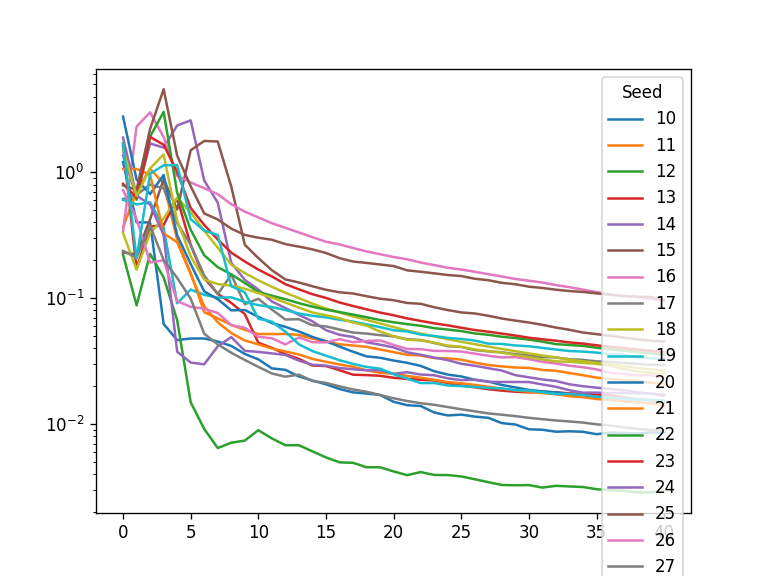

In [11]:
sample = samples[94]
print zip(keys, sample)
fig, ax1 = plt.subplots()
ax1.semilogy()
for i in range(len(lc[tuple(sample)])):
    l = lc[tuple(sample)][i]
    ax1.plot(l["Epoch"], l["Energy"], '-', label=r'{0:d}'.format(seeds[i]))
ax1.legend(title=r'Seed')

[('kalman_epsilon', 0.10000000000000001), ('kalman_lambda_short', 0.91000000000000003), ('kalman_nue_short', 0.93999999999999995)]


<IPython.core.display.Javascript object>


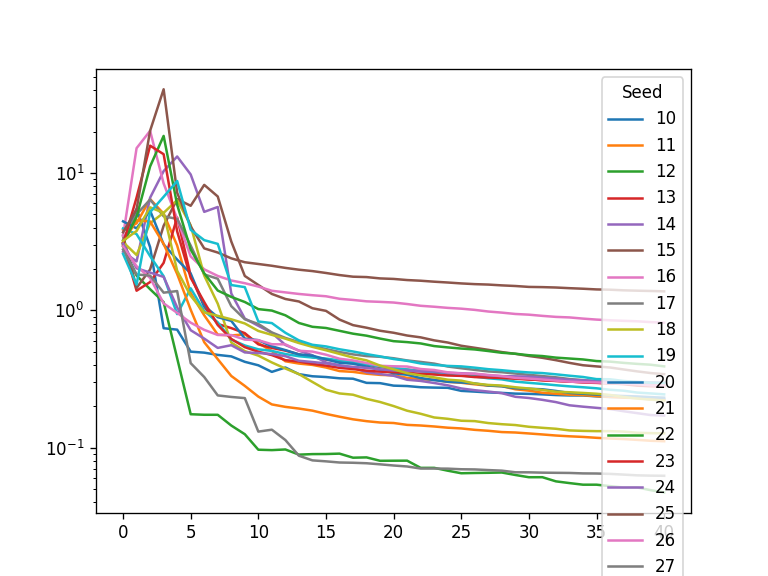

In [12]:
print zip(keys, sample)
fig, ax1 = plt.subplots()
ax1.semilogy()
for i in range(len(lc[tuple(sample)])):
    l = lc[tuple(sample)][i]
    ax1.plot(l["Epoch"], l["Force"], '-', label=r'{0:d}'.format(seeds[i]))
ax1.legend(title=r'Seed')